In [1]:
import sympy
import symnum
import symnum.numpy as snp
import simsde
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import cho_solve
from jax.scipy.special import ndtr, ndtri
from jax import jit, vmap, grad, value_and_grad
from jax.lax import scan
from jax.example_libraries.optimizers import adagrad, adam
import matplotlib.pyplot as plt
from jax.config import config
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

## Model functions

In [2]:
def drift_func_rough(x, θ):
    A, B, a, b, C, ν_max, v_0, r, μ_0, μ_1, μ_2, *_ = θ
    C_1 = C
    C_2 = 0.8 * C
    C_3 = C_4 = 0.25 * C
    sigmoid = lambda y: ν_max / (1 + snp.exp(r * (v_0 - y)))
    return snp.array([
        A * a * (μ_0 + sigmoid(x[4] - x[5])) - 2 * a * x[0] - a**2 * x[3],
        A * a * (μ_1 + C_2 * sigmoid(C_1 * x[3])) - 2 * a * x[1] - a**2 * x[4],
        B * b * (μ_2 + C_4 * sigmoid(C_3 * x[3])) - 2 * b * x[2] - b**2 * x[5],
    ])  

def drift_func_smooth(x, θ):
    return x[:3]  

def diff_coeff_rough(x, θ):
    *_, σ_0, σ_1, σ_2 = θ
    return snp.array([[σ_0, 0, 0], [0, σ_1, 0], [0, 0, σ_2]])

def drift_func(x, θ):
    return snp.concatenate((drift_func_rough(x, θ), drift_func_smooth(x, θ)))

def diff_coeff(x, θ):
    return snp.concatenate((diff_coeff_rough(x, θ), snp.zeros((dim_x - dim_r, dim_w))), 0)

dim_x = 6
dim_r = 3
dim_w = 3
dim_θ = 14

## Simulating paths

In [3]:
dim_n, step_func = {
    "euler_maruyama": (
        dim_r,
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
    ),
    "weak_order_2": (
        4 * dim_r - 1,
        simsde.integrators.hypoelliptic_weak_order_2_step(
            drift_func_rough, drift_func_smooth, diff_coeff_rough
        ),
    ),
    "local_gaussian": (
        2 * dim_r,
        simsde.integrators.hypoelliptic_local_gaussian_step(
            drift_func_rough, drift_func_smooth, diff_coeff_rough
        ),
    )
}["weak_order_2"]

jax_step_func = symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)


In [4]:
@jit
def simulate_diffusion(x_0, θ, t_seq, n_seq):
    
    def step_func(x, n_dt):
        n, dt = n_dt
        x_next = jax_step_func(x, θ, n, dt)
        return x_next, x_next
    
    _, x_seq = scan(step_func, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
    
    return jnp.concatenate((x_0[None], x_seq))

vmapped_simulate_diffusion = jit(vmap(simulate_diffusion, (None, None, None, 0)))

In [5]:
rng = np.random.default_rng(1234)
dt = 1e-4
t_min = 5.
t_max = 25.
x_0 = np.array([-0.5, 0, 0, 0.08, 18, 15])

t_seq_sim = np.arange(int(t_max / dt) + 1) * dt

parameter_values = {
    "A": 3.25, 
    "B": 22, 
    "a": 100, 
    "b": 50, 
    "C": 135., 
    "ν_max": 5, 
    "v_0": 6, 
    "r": 0.56, 
    "μ_0": 0., 
    "μ_1": 220., 
    "μ_2": 0., 
    "σ_0": 0.01, 
    "σ_1": 2000., 
    "σ_2": 1.,
}
θ_true = np.array(list(parameter_values.values()))

n_seqs = rng.standard_normal((20, t_seq_sim.shape[0] - 1, dim_n))
x_seqs_sim = vmapped_simulate_diffusion(x_0, θ_true, t_seq_sim, n_seqs)

t_seq = t_seq_sim[int(t_min / dt):]
x_seqs = x_seqs_sim[:, int(t_min / dt):]

Text(0.5, 0, 'Time')

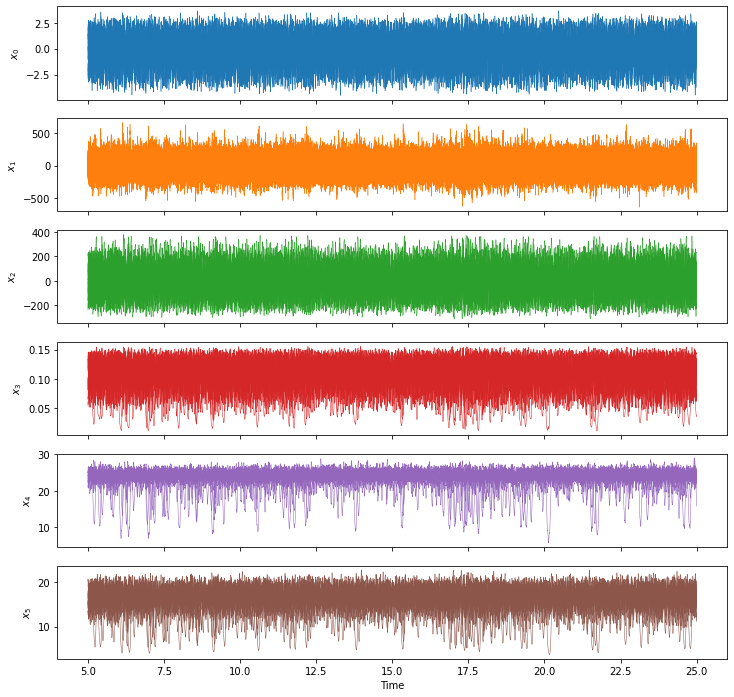

In [6]:
fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = [f'$x_{i}$' for i in range(dim_x)]
for i, ax in enumerate(axes):
    ax.plot(t_seq, x_seqs[:, :, i].T, color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel('Time')

Text(0.5, 0, 'Time')

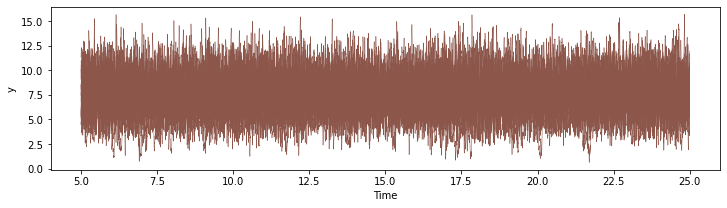

In [7]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t_seq, (x_seqs[:, :, 4] - x_seqs[:, :, 5]).T, color=f'C{i}', lw=0.5)
ax.set_ylabel("y")
ax.set_xlabel('Time')

## Approximate transition densities

In [8]:
symolic_log_transition_density_generators = {
    'local_gaussian': simsde.densities.local_gaussian_log_transition_density,
    'improved_scheme (contrast)': simsde.densities.improved_scheme_log_transition_density_proxy,
}
jax_log_transition_densities = {
    key: symnum.numpify(dim_x, dim_x, dim_θ, None, numpy_module=jnp)(
        symbolic_transition_density_generator(
            drift_func_rough, drift_func_smooth, diff_coeff_rough
        )
    )
    for key, symbolic_transition_density_generator in 
    symolic_log_transition_density_generators.items()
}

## Log-likelihood functions

In [9]:
def logit(u):
    return jnp.log(u / (1 - u))
    
def sigmoid(u):
    return 1 / (1 + jnp.exp(-u))

free_parameter_ranges = {
    "C": (129, 141),
    "μ_1": (160, 280),
    "σ_1": (1300, 2700),
}

def generate_θ(u, parameter_values, free_parameter_ranges):
    params = parameter_values.copy()
    for i, (name, (lower, upper)) in enumerate(free_parameter_ranges.items()):
        params[name] = lower + ndtr(u[i]) * (upper - lower)
    return jnp.array(list(params.values()))


def inv_generate_θ(θ, parameter_values, free_parameter_ranges):
    params = {name: value for name, value in zip(parameter_values.keys(), θ)}
    return jnp.array(
        [
            ndtri((params[name] - lower) / (upper - lower))
            for name, (lower, upper) in free_parameter_ranges.items()
        ]
    )

def get_log_likelihood_functions(
    log_transition_density, parameter_values, free_parameter_ranges
):

    @jit
    def log_likelihood_θ(θ, x_seq, t_seq):
        log_transition_density_terms = vmap(log_transition_density, (0, 0, None, 0))(
            x_seq[1:], x_seq[:-1], θ, t_seq[1:] - t_seq[:-1]
        )
        return log_transition_density_terms.sum()
        
    @jit
    def log_likelihood_u(u, x_seq, t_seq):
        return log_likelihood_θ(
            generate_θ(u, parameter_values, free_parameter_ranges), x_seq, t_seq
        )
        
    return {'u': log_likelihood_u, 'θ': log_likelihood_θ}


In [10]:
def plot_log_likelihood(
    log_likelihood, x_seq, t_seq, parameter_values, free_parameter_ranges, n_grid=101
):
    vmapped_log_likelihood_θ = jit(vmap(log_likelihood["θ"], (0, None, None)))
    vmapped_generate_θ = vmap(
        lambda u: generate_θ(u, parameter_values, free_parameter_ranges)
    )
    
    def parameter_and_log_likelihood_grids(u_ranges):
        u_grid = np.stack(np.meshgrid(*u_ranges), -1).reshape((-1, n_free_parameters))
        θ_grid = vmapped_generate_θ(u_grid)
        log_likelihood_grid = vmapped_log_likelihood_θ(θ_grid, x_seq, t_seq)
        return u_grid, θ_grid, log_likelihood_grid

    n_free_parameters = len(free_parameter_ranges)
    fig, axes = plt.subplots(
        2 * n_free_parameters, 
        n_free_parameters, 
        figsize=(n_free_parameters * 4, n_free_parameters * 8)
    )
    axes_u, axes_θ = axes[:n_free_parameters], axes[n_free_parameters:]
    parameter_names = list(parameter_values.keys())
    θ_free_indices = [parameter_names.index(name) for name in free_parameter_ranges]
    θ_true = list(parameter_values.values())
    u_true = inv_generate_θ(θ_true, parameter_values, free_parameter_ranges)
    for u_index_1, θ_index_1 in enumerate(θ_free_indices):
        u_ranges = list(u_true)
        u_ranges[u_index_1] = np.linspace(-3, 3, n_grid)
        u_grid, θ_grid, log_likelihood_grid = parameter_and_log_likelihood_grids(u_ranges)
        for ax, param_label, param_grid, param_true, param_index in [
            (axes_u[u_index_1, u_index_1], "u", u_grid, u_true, u_index_1),
            (axes_θ[u_index_1, u_index_1], "\\theta", θ_grid, θ_true, θ_index_1),
        ]:
            ax.autoscale(True, tight=True)
            ax.plot(param_grid[:, param_index], log_likelihood_grid)
            ax.plot(
                [param_true[param_index], param_true[param_index]],
                ax.get_ylim(),
                '--'
            )
            ax.set(
                xlabel=f"${param_label}_{{{param_index}}}$", ylabel="Log-likelihood"
            )
        for u_index_2, θ_index_2 in enumerate(θ_free_indices):
            if u_index_2 >= u_index_1:
                if u_index_2 > u_index_1:
                    axes_u[u_index_1, u_index_2].set_axis_off()
                    axes_θ[u_index_1, u_index_2].set_axis_off()
                continue
            u_ranges[u_index_2] = np.linspace(-3, 3, n_grid)
            u_grid, θ_grid, log_likelihood_grid = parameter_and_log_likelihood_grids(u_ranges)
            for ax, param_label, param_grid, param_index_1, param_index_2 in [
              (axes_u[u_index_1, u_index_2], "u", u_grid, u_index_1, u_index_2),
              (axes_θ[u_index_1, u_index_2], "\\theta", θ_grid, θ_index_1, θ_index_2),
            ]:
                ax.pcolormesh(
                    param_grid[:, param_index_2].reshape((n_grid, n_grid)),
                    param_grid[:, param_index_1].reshape((n_grid, n_grid)),
                    log_likelihood_grid.reshape((n_grid, n_grid)),
                )
                ax.set(
                    xlabel=f"${param_label}_{{{param_index_2}}}$", 
                    ylabel=f"${param_label}_{{{param_index_1}}}$"
                )
            u_ranges[u_index_2] = u_true[u_index_2]
    return fig, axes         


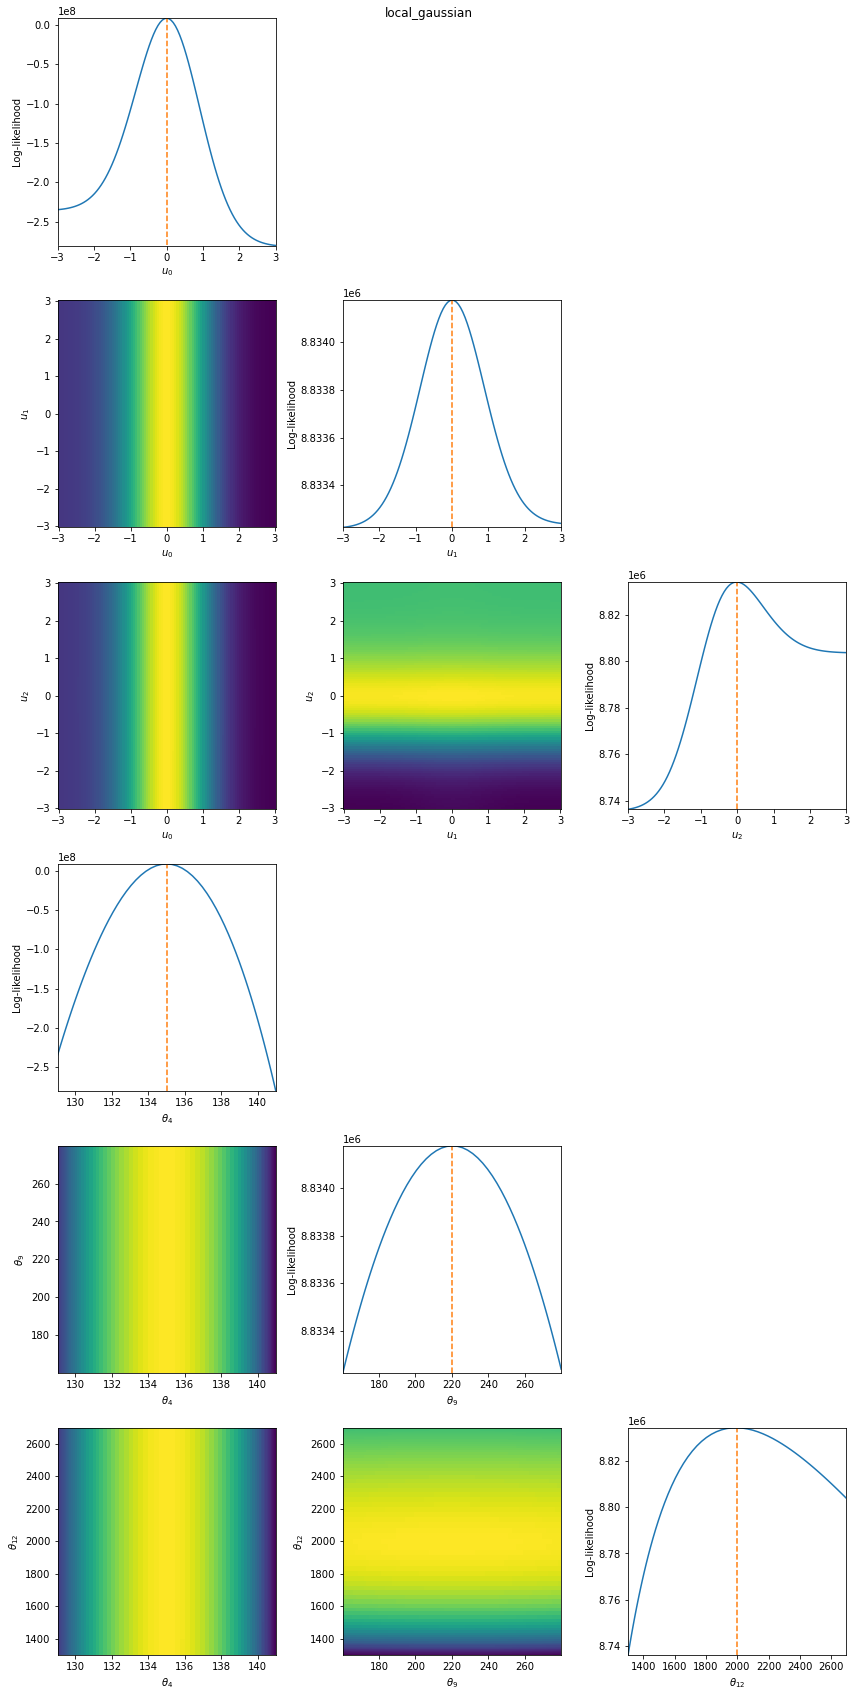

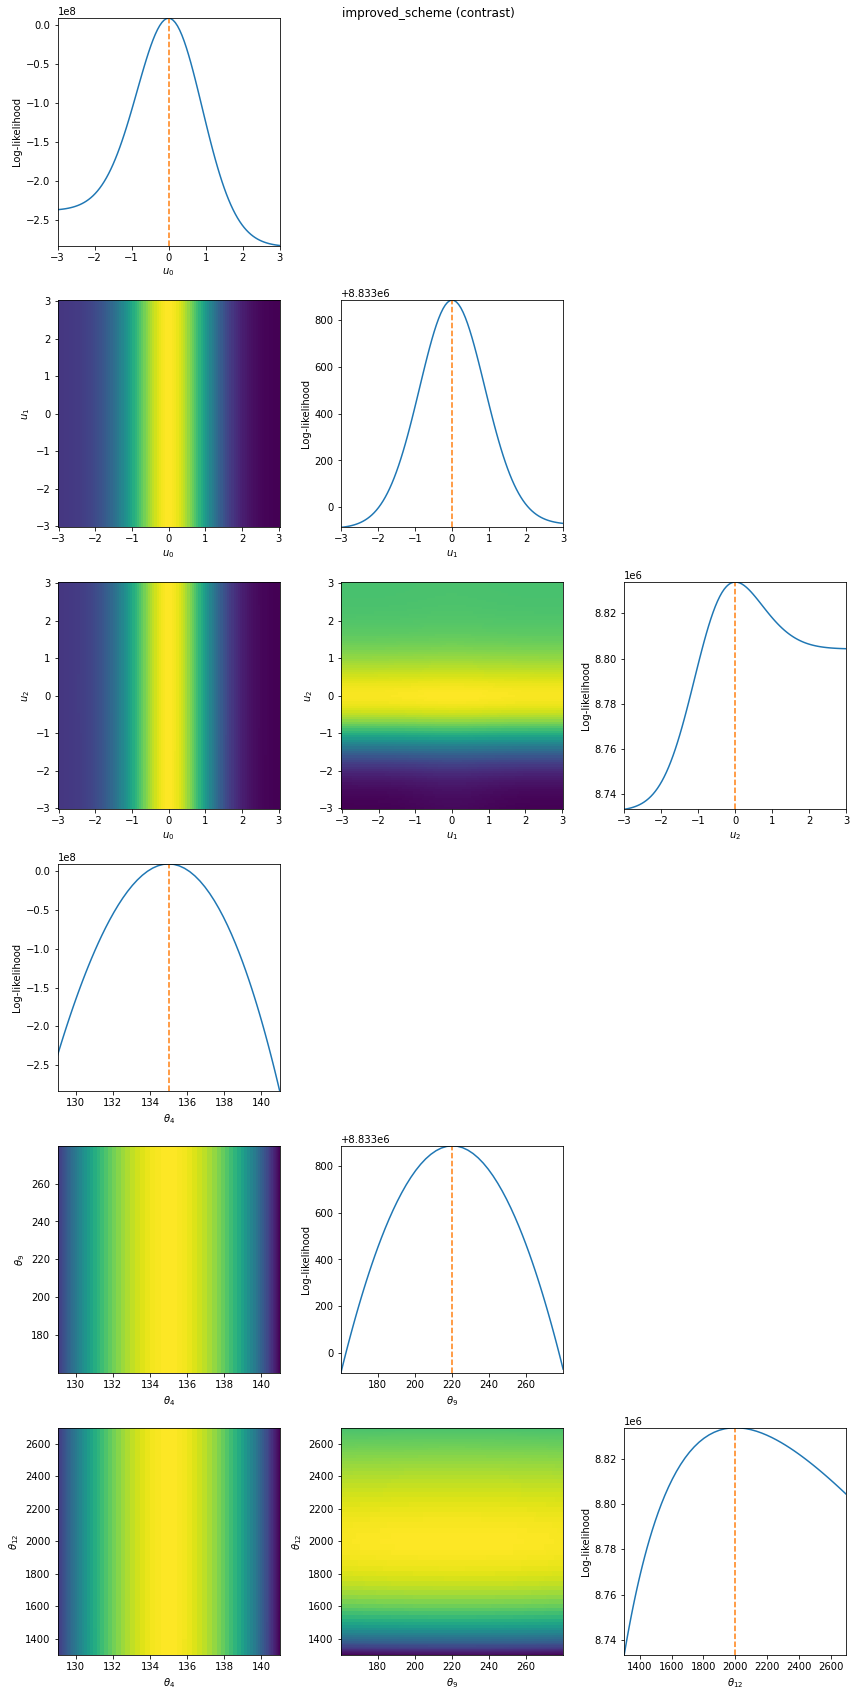

In [11]:
for scheme, log_transition_density in jax_log_transition_densities.items():
    log_likelihood = get_log_likelihood_functions(
        log_transition_density, parameter_values, free_parameter_ranges
    )
    fig, axes = plot_log_likelihood(
        log_likelihood, x_seqs[0], t_seq, parameter_values, free_parameter_ranges
    )
    fig.suptitle(scheme)
    fig.tight_layout()
    

## Convergence of maximum likelihood estimates with time step

Computing ML estimates for local_gaussian scheme with Δt=0.1
Computing ML estimates for local_gaussian scheme with Δt=0.05
Computing ML estimates for local_gaussian scheme with Δt=0.02
Computing ML estimates for local_gaussian scheme with Δt=0.01
Computing ML estimates for local_gaussian scheme with Δt=0.005
Computing ML estimates for local_gaussian scheme with Δt=0.002
Computing ML estimates for local_gaussian scheme with Δt=0.001
Computing ML estimates for improved_scheme (contrast) scheme with Δt=0.1
Computing ML estimates for improved_scheme (contrast) scheme with Δt=0.05
Computing ML estimates for improved_scheme (contrast) scheme with Δt=0.02
Computing ML estimates for improved_scheme (contrast) scheme with Δt=0.01
Computing ML estimates for improved_scheme (contrast) scheme with Δt=0.005
Computing ML estimates for improved_scheme (contrast) scheme with Δt=0.002
Computing ML estimates for improved_scheme (contrast) scheme with Δt=0.001


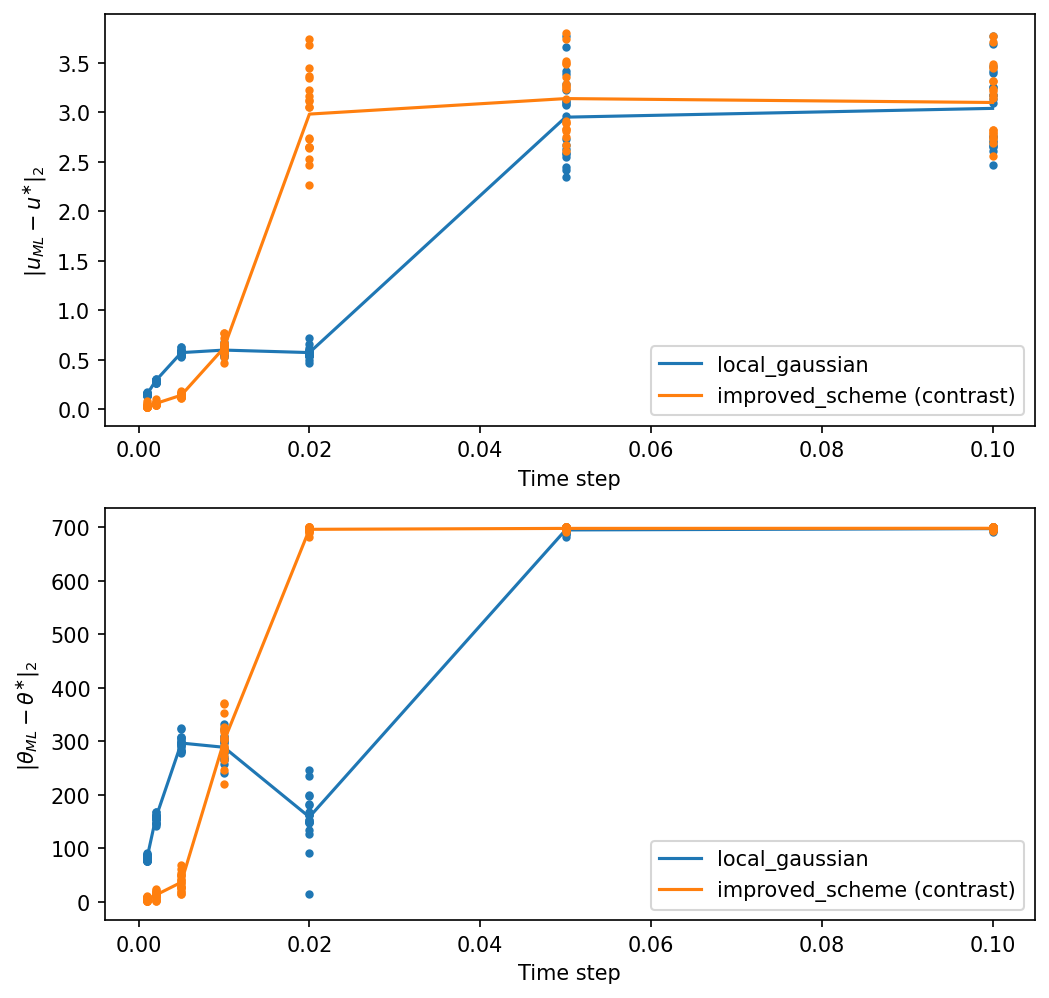

In [12]:
def compute_maximum_likelihood_estimates(
    log_likelihood, t_seq, x_seqs, u_inits, optimizer=adam, n_steps=2000, step_size=1e-2
):
    optimizer_init, optimizer_update, optimizer_get_params = optimizer(step_size)
    
    def optimizer_step(step_index, state, x_seq, t_seq):
        value, grad = value_and_grad(log_likelihood["u"])(
            optimizer_get_params(state), x_seq, t_seq
        )
        state = optimizer_update(step_index, -grad, state)
        return value, state

    vmapped_optimizer_step = jit(vmap(optimizer_step, (None, 0, 0, None)))
    
    state = vmap(optimizer_init)(u_inits)

    for s in range(n_steps):
        _, state = vmapped_optimizer_step(s, state, x_seqs, t_seq)
        
    return optimizer_get_params(state)
    
vmapped_generate_θ = vmap(
    lambda u: generate_θ(u, parameter_values, free_parameter_ranges)
)

seed = 2022081734
rng = np.random.default_rng(seed)
u_inits = rng.standard_normal(size=(len(x_seqs), len(free_parameter_ranges)))
θ_true = np.array(list(parameter_values.values()))
u_true = inv_generate_θ(θ_true, parameter_values, free_parameter_ranges)
subsample_factors = np.array([1000, 500, 200, 100, 50, 20, 10])
time_steps = (t_seq[-1] - t_seq[0]) / ((t_seq.shape[0] - 1) / subsample_factors)
distances = {
    scheme: {k: np.full((len(subsample_factors), len(x_seqs)), np.nan) for k in "uθ"}
    for scheme in jax_log_transition_densities
}
for scheme, log_transition_density in jax_log_transition_densities.items():
    log_likelihood = get_log_likelihood_functions(
        log_transition_density, parameter_values, free_parameter_ranges
    )
    for i, subsample in enumerate(subsample_factors):
        print(f"Computing ML estimates for {scheme} scheme with Δt={time_steps[i]}")
        u_ml_estimates = compute_maximum_likelihood_estimates(
            log_likelihood, t_seq[::subsample], x_seqs[:, ::subsample], u_inits
        )
        θ_ml_estimates = vmapped_generate_θ(u_ml_estimates)
        distances[scheme]["u"][i] = ((u_ml_estimates - u_true)**2).sum(-1)**0.5
        distances[scheme]["θ"][i] = ((θ_ml_estimates - θ_true)**2).sum(-1)**0.5

fig, axes = plt.subplots(2, figsize=(8, 8), dpi=150)
for ax, parameterization in zip(axes, "uθ"):
    for scheme, color in zip(jax_log_transition_densities, ("C0", "C1")):
        ax.plot(time_steps, distances[scheme][parameterization], '.', color=color)
        ax.plot(
            time_steps, 
            distances[scheme][parameterization].mean(-1), 
            '-', 
            color=color, 
            label=scheme
        )
    ax.set(
        xlabel='Time step', 
        ylabel=f'$\\|{parameterization}_{{ML}} - {parameterization}^{{\\ast}}\\|_2$'
    )
    ax.legend()